<a href="https://colab.research.google.com/github/ayrna/deep-learning-with-python-notebooks/blob/master/chapter03_introduction-to-keras-and-tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carlos Checa Moreno

i02chmoc@uco.es

Este cuaderno está basado en los cuadernos del libro [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff).

> This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.
> **If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**
> This notebook was generated for TensorFlow 2.6.

# Introducción a Keras y TensorFlow

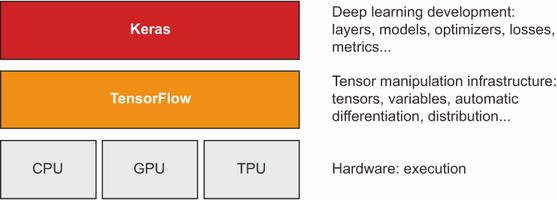

Keras acaba de publicar como estable la versión 3.0, que incluye más "motores" de deep learning además de TensorFLow.

https://keras.io/

Puede interesarte mirar la galería de ejemplos:

https://keras.io/examples/

## Primeros pasos con TensorFlow

Entrenar redes neuronales gira en torno a varios conceptos:

1. La manipulación de tensores, la *infraestructura* que subyace a todo el aprendizaje automático moderno. Esto se traduce en las APIs de **TensorFlow**:
 * *Tensores*, incluyendo tensores especiales que almacenan el estado de la red (variables)
 * *Operaciones de tensor* como la `suma`, `relu`, `matmul`
 * *Retropropagación (Backpropagation)*, una forma de calcular el gradiente de expresiones matemáticas (usado TensorFlow a través del objeto `GradientTape`)
2. Conceptos de aprendizaje profundo de alto nivel. Esto se traduce en las APIs de **Keras**:
 * *Capas*, que se combinan en un modelo
 * *Función de pérdida*, que define la señal de retroalimentación utilizada para el aprendizaje
 * *Optimizador*, que determina cómo se realiza el ajuste/aprendizaje a los datos.
 * *Métricas* para evaluar el rendimiento del modelo, como la precisión
 * Un *bucle de entrenamiento* que realiza el descenso de gradiente estocástico en mini lotes

#### Tensores constantes y variables

Los tensores son la estructura de datos básica de TensorFlow y Keras. Deben crearse con un contenido y no se les puede asignar un valor.

Cuando es necesario cambiar el estado de una variable necesitaremos el tipo `tf.Variable`, que deben crearse con un valor inicial también.

**All-ones o all-zeros tensors**

In [3]:
import tensorflow as tf
x = tf.ones(shape=(2, 1))
print(x)

tf.Tensor(
[[1.]
 [1.]], shape=(2, 1), dtype=float32)


In [4]:
x = tf.zeros(shape=(2, 1))
print(x)

tf.Tensor(
[[0.]
 [0.]], shape=(2, 1), dtype=float32)


**Tensores aleatorios**

In [5]:
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)
print(x)

tf.Tensor(
[[-1.5847777 ]
 [-0.8973643 ]
 [-0.18537149]], shape=(3, 1), dtype=float32)


In [6]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.7624879 ]
 [0.7936094 ]
 [0.14819813]], shape=(3, 1), dtype=float32)


**Los arrays de NumPy son asignables pero los tensores no**

In [7]:
import numpy as np
x = np.ones(shape=(2, 2))
x[0, 0] = 0.

In [8]:
try:
  x = tf.ones(shape=(2, 2))
  x[0, 0] = 0.
except Exception as e:
  print(e)

'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment


**Crear un TensorFlow variable**

In [9]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[ 1.3490717 ],
       [-0.06957707],
       [-1.0515014 ]], dtype=float32)>


**Asignar un valor a un TensorFlow variable**

In [10]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

**Asignar un valor a un subconjunto de un TensorFlow variable**

In [11]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

**Suma con `assign_add`**

In [12]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

#### Operaciones matemáticas con Tensores

**Operaciones básicas**

In [13]:
a = tf.ones((2, 2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a, b)
e *= d

#### GradientTape API

**Cómo usar `GradientTape`**

Basta con abrir un *ámbito* de `GradientTape`, aplicar algún cálculo a uno o varios tensores de entrada, y recuperar el gradiente del resultado con respecto a las entradas.

$f(x)=x^2$

$
\frac{\partial f}{\partial x} = 2x
$



In [14]:
input_var = tf.Variable(initial_value=3.)
with tf.GradientTape() as tape:
   result = tf.square(input_var)
gradient = tape.gradient(result, input_var)
# la función sería f(x)=x^2; f'(x)=2x, siendo x = 3 f'(x)=6
print(input_var)
print(gradient)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>
tf.Tensor(6.0, shape=(), dtype=float32)


**`GradientTape` con tensores constantes como entrada**

Hasta ahora, sólo hemos visto el caso en que los tensores de entrada en `tape.gradient()` eran variables TensorFlow. En realidad es posible que estas entradas sean cualquier tensor arbitrario. Sin embargo, sólo las variables entrenables son *rastreadas* por defecto. Con un tensor constante, hay que marcarlo manualmente como rastreado llamando a `tape.watch()` sobre él. Esto se hace por motivos de eficiencia computacional.

In [15]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
   tape.watch(input_const)
   result = tf.square(input_const)
gradient = tape.gradient(result, input_const)
print(result)
print(gradient)

tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)


#### Un clasificador lineal completo en TensorFlow

**Generación del conjunto de datos**

In [16]:
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)

****** vstack para concatenar matrices verticalmente, hstack horizontalmente

In [17]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

In [18]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

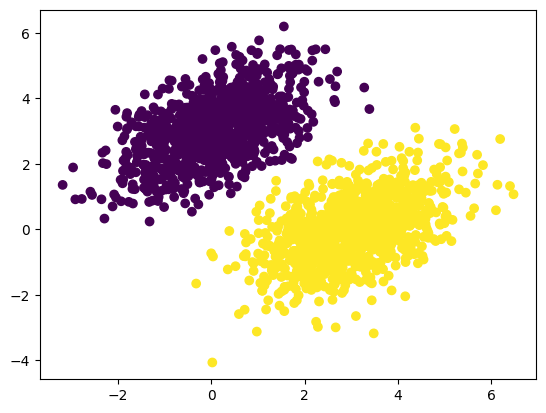

In [19]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**Creación de la variables del modelo lineal**

Inicializamos `W` con valores aleatorios y `b` a cero.


In [20]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

**Propagación hacia delante**

In [21]:
def model(inputs):
    return tf.matmul(inputs, W) + b

**Función de pérdia de error cuadrático medio (MSE)**

* `persample_loss` es un tensor con la misma forma que targets y predictions y almacenará la pérdida correspondiente a cada patrón.
* Devolvemos la contribución media al error del lote. `reduce_mean` por defecto reduce todas las dimensiones a 1, pero podría utilizarse para calcular medias por ejes del tensor.

In [22]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

def root_square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.sqrt(tf.reduce_mean(per_sample_losses))

**El paso de entrenamiento**

Recordad que `GradientTape` nos permite derivar respecto a listas de parámetros. En este caso nos devuelve el gradiente parcial respecto a cada parámetro de la lista.

In [23]:
learning_rate = 0.01

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        #loss = square_loss(targets, predictions)
        loss = root_square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    # Actualizamos los pesos restando el gradiente (dirección contraria)
    W.assign_sub(grad_loss_wrt_W * learning_rate)
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

**Bucle de aprendizaje con el conjunto completo (batch training)**

Para simplificar, haremos un entrenamiento por lotes en lugar de un mini-entrenamiento por lotes: ejecutaremos cada paso de entrenamiento (cálculo del gradiente y actualización de pesos) para todos los datos, en lugar de iterar sobre los datos en pequeños lotes.

Esto significa que cada paso de entrenamiento tardará mucho más tiempo en ejecutarse pero cada actualización del gradiente será mucho más eficaz para reducir la función de pérdida al incluir todos los datos de entrenamiento. Esto significa que harán falta menos pasos de entrenamiento y que la tasa de aprendizaje debería ser mayor que al utilizar lotes pequeños (`learning_rate = 0.1`).

❓❓❓ **EJERCICIO**
* Prueba a utilizar distintas tasas de aprendizaje en este ejemplo y observa el resultado
* ¿[Tiene sentido que la tasa de aprendizaje sea mayor que 1](https://ai.stackexchange.com/questions/23740/why-is-the-learning-rate-generally-beneath-1)?
* Intenta programar otra función de pérdida: el RMSE.

❓❓❓

No tiene sentido una tasa de aprendizaje mayor que 1 porque si la tasa de aprendizaje es mayor que 1, los pesos se actualizarán demasiado rápido y la red neuronal no podrá converger a una solución óptima

In [24]:
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 0.3581
Loss at step 1: 0.3409
Loss at step 2: 0.3278
Loss at step 3: 0.3181
Loss at step 4: 0.3110
Loss at step 5: 0.3056
Loss at step 6: 0.3016
Loss at step 7: 0.2984
Loss at step 8: 0.2958
Loss at step 9: 0.2935
Loss at step 10: 0.2915
Loss at step 11: 0.2896
Loss at step 12: 0.2879
Loss at step 13: 0.2862
Loss at step 14: 0.2846
Loss at step 15: 0.2830
Loss at step 16: 0.2814
Loss at step 17: 0.2799
Loss at step 18: 0.2784
Loss at step 19: 0.2768
Loss at step 20: 0.2753
Loss at step 21: 0.2738
Loss at step 22: 0.2724
Loss at step 23: 0.2709
Loss at step 24: 0.2694
Loss at step 25: 0.2679
Loss at step 26: 0.2665
Loss at step 27: 0.2650
Loss at step 28: 0.2636
Loss at step 29: 0.2622
Loss at step 30: 0.2608
Loss at step 31: 0.2594
Loss at step 32: 0.2580
Loss at step 33: 0.2566
Loss at step 34: 0.2552
Loss at step 35: 0.2538
Loss at step 36: 0.2524
Loss at step 37: 0.2511
Loss at step 38: 0.2497
Loss at step 39: 0.2484


Como vemos la función de pérdida más o menos se estabiliza.

Ahora vamos a predecir la clase de los patrones. En este ejemplo de clasificación binaria el umbral de decisión entre las clases es `0.5` donde se asigna la clase "1" para los valores mayores que el umbral.

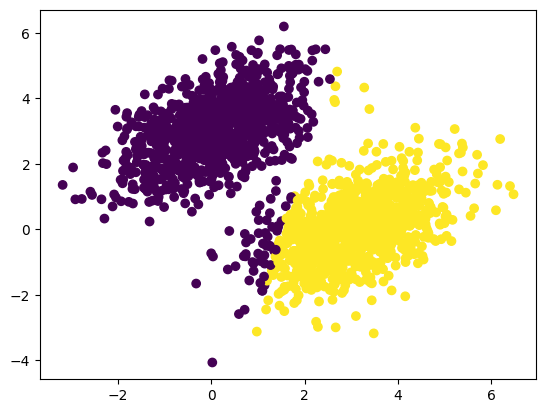

In [25]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

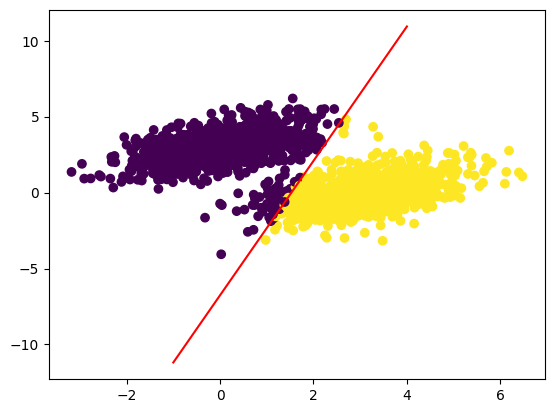

In [26]:
x = np.linspace(-1, 4, 100)
y = - W[0] /  W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## Anatomía de una red neuronal para entender conceptos de Keras

### Capas (Layers)

La estructura de datos fundamental en las redes neuronales es la *capa*. Una capa es un módulo de procesamiento de datos que toma como entrada uno o más tensores y que da como salida uno o más tensores. Algunas capas no tienen estado, pero lo más frecuente es que las capas tengan un estado: los *pesos* de la capa, uno o varios tensores aprendidos con el descenso por gradiente, que en conjunto almacenan el *conocimiento* de la red.

Según el tipo de dato con el que trabajemos habrá tipos de capas más apropiados para trabajar con estos.
* Datos vectoriales simples, también llamados tabulares ("hoja de cálculo"), almacenados en tensores de rango 2 `(muestra, características)`, suelen ser procesados por capas densamente conectadas, también llamadas capas totalmente conectadas (la clase `Dense` en Keras).
* Los datos con disposición temporal o de secuencia, tensores de rango 3 `(muestras, pasos de tiempo, características)`, se procesan normalmente por capas recurrentes, como una capa `LSTM`, o capas de convolución 1D (`Conv1D`).
* Los datos de imágenes, almacenados en tensores de rango 4, suelen ser procesados por capas de convolución 2D (`Conv2D`).

#### La clase `Layer` en Keras


Casi todo en Keras gira en torno a un objeto de tipo Layer, que encapsula un estado de los pesos y un cálculo sobre la red (*forward pass*). Los pesos se definen en `build()` y el procesamiento en `call()`.


**Una capa `Dense` implementada como subclase de `Layer`**

In [27]:
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        super().__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units),
                                 initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,),
                                 initializer="zeros")

    def call(self, inputs):
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
            y = self.activation(y)
        return y

Esta capa que hemos creado se puede instanciar y usarse como una función:

In [28]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 32)


In [29]:
my_dense = SimpleDense(units=512, activation=tf.nn.tanh)
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)
print(output_tensor.shape)

(2, 512)


#### Deducción de la forma de la capa automática: construcción de capas sobre la marcha

En Keras en general sólo necesitaremos especificar la forma de los tensores de salida de la capa, ya que las capas que se añaden al modelo se construyen dinámicamente para adaptar cada capa a la forma de la capa de entrada (la salida de la capa anterior).

La siguiente capa sólo puede conectarse a una capa que espere vectores de 32 dimensiones como entrada.

In [30]:
from tensorflow.keras import layers
layer = layers.Dense(32, activation="relu")

En Keras, no se implementa la construcción de la capa del todo en el constructor `__build__()` en espera de conocer cuál será la forma de la entrada desde la capa anterior.

In [31]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(32)
])

En el ejemplo de red que hicimos desde cero necesitábamos especificar perfectamente las dimensiones de entrada y salida de la secuencia de capas:

```
model = NaiveSequential([
    NaiveDense(input_size=784, output_size=32, activation="relu"),
    NaiveDense(input_size=32, output_size=64, activation="relu"),
    NaiveDense(input_size=64, output_size=32, activation="relu"),
    NaiveDense(input_size=32, output_size=10, activation="softmax")
])
```



En Keras basta con lo siguiente:

In [32]:
model = keras.Sequential([
    SimpleDense(32, activation="relu"),
    SimpleDense(64, activation="relu"),
    SimpleDense(32, activation="relu"),
    SimpleDense(1, activation="softmax")
])

### De las capas a los modelos

Un modelo de aprendizaje profundo consiste en un grafo de capas, clase `Model` en Keras. Hasta ahora sólo hemos visto el modelo `Sequential`, que es una subclase de `Model` pero existen muchas otras topologías de red más avanzadas (Transformers, [`Residual`](https://keras.io/api/applications/resnet/)...)

### El paso "compile" para configurar el proceso de aprendizaje

Aquí vamos a configurar:
* Función de pérdida (o función objetivo).
* El optimizador.
* Métricas de evaluación sobre el conjunto de train y opcionalmente validación.

Hay dos alternativas para especificar esto:

In [33]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer="rmsprop",
              loss="mean_squared_error",
              metrics=["accuracy"])

In [34]:
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

### La importancia de la función de pérdida ❗❗❗❗

La elección de la función de pérdida correcta para el problema adecuado es extremadamente importante: la red tomará cualquier atajo que pueda para minimizar la pérdida, por lo que si el objetivo no está totalmente correlacionado con la tarea en cuestión, la red terminará haciendo cosas que probablemente no queramos.

Ejemplos:
* ¿detector de emociones?
* ¿maximizar el bienestar promedio de los seres humanos?
* [Hundreds of AI tools have been built to catch covid. None of them helped.](https://www.technologyreview.com/2021/07/30/1030329/machine-learning-ai-failed-covid-hospital-diagnosis-pandemic/)
* [Leakage and the reproducibility crisis in machine-learning-based science](https://www.sciencedirect.com/science/article/pii/S2666389923001599)

### El método fit()

**Calling `fit()` with NumPy data**

In [35]:
history = model.fit(
    inputs,
    targets,
    epochs=5,
    batch_size=128
)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - binary_accuracy: 0.0153 - loss: 17.1968
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.0167 - loss: 16.6458
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.0183 - loss: 16.2952  
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.0215 - loss: 15.2015
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.0213 - loss: 15.4846


In [36]:
history.history

{'binary_accuracy': [0.01899999938905239,
  0.01899999938905239,
  0.019999999552965164,
  0.019999999552965164,
  0.020500000566244125],
 'loss': [16.805198669433594,
  16.304487228393555,
  15.879100799560547,
  15.464550971984863,
  15.06027889251709]}

### Monitorización de la pérdida y las métricas sobre datos de validación

**Parámetro `validation_data`**


In [37]:
model = keras.Sequential([keras.layers.Dense(1)])
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.1),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.BinaryAccuracy()])

indices_permutation = np.random.permutation(len(inputs))
shuffled_inputs = inputs[indices_permutation]
shuffled_targets = targets[indices_permutation]

num_validation_samples = int(0.3 * len(inputs))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]
model.fit(
    training_inputs,
    training_targets,
    epochs=5,
    batch_size=16,
    validation_data=(val_inputs, val_targets)
)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - binary_accuracy: 0.7068 - loss: 1.7928 - val_binary_accuracy: 0.9917 - val_loss: 0.0632
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.9525 - loss: 0.0805 - val_binary_accuracy: 0.9717 - val_loss: 0.0919
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.9494 - loss: 0.0807 - val_binary_accuracy: 0.9817 - val_loss: 0.0647
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_accuracy: 0.9534 - loss: 0.0660 - val_binary_accuracy: 0.8533 - val_loss: 0.1799
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.9528 - loss: 0.0705 - val_binary_accuracy: 1.0000 - val_loss: 0.0261


### Cómo usar el modelo entrenado

Se puede llamar al modelo como una función, pero esto evaluaría toda la base de datos de test directamente en lugar de por lotes.

```
predictions = model(new_inputs)
```

Habitualmente será más adecuado usar la función `predict`

In [38]:
predictions = model.predict(val_inputs, batch_size=128)
print(predictions[:10])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[-0.01091015]
 [ 0.6689131 ]
 [ 0.21068162]
 [ 0.959407  ]
 [ 0.09712133]
 [ 0.15849051]
 [ 0.15613854]
 [ 0.2721038 ]
 [ 0.08747506]
 [ 0.9212561 ]]


❓❓❓
**EJERCICIO**

* Prueba a utilizar el modelo anterior de 4 capas con la base de datos MNIST
  * No bastará con copiar y pegar. Presta atención a: variables de entrada, función de pérdida adecuada, neuronas por capa... Deberás calcular la precisión media en test.
* Prueba a visualizar el historial de ajuste del modelo

❓❓❓

In [39]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [41]:
model = keras.Sequential([
    keras.layers.Dense(512, activation="relu", input_shape=(28 * 28,)),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    x_train,
    y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.2
)

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.8374 - loss: 0.5119 - val_accuracy: 0.9657 - val_loss: 0.1171
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9685 - loss: 0.1056 - val_accuracy: 0.9642 - val_loss: 0.1170
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9797 - loss: 0.0655 - val_accuracy: 0.9732 - val_loss: 0.0896
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9861 - loss: 0.0438 - val_accuracy: 0.9696 - val_loss: 0.1113
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9909 - loss: 0.0291 - val_accuracy: 0.9752 - val_loss: 0.1025


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9724 - loss: 0.1014
Test accuracy: 0.975600004196167


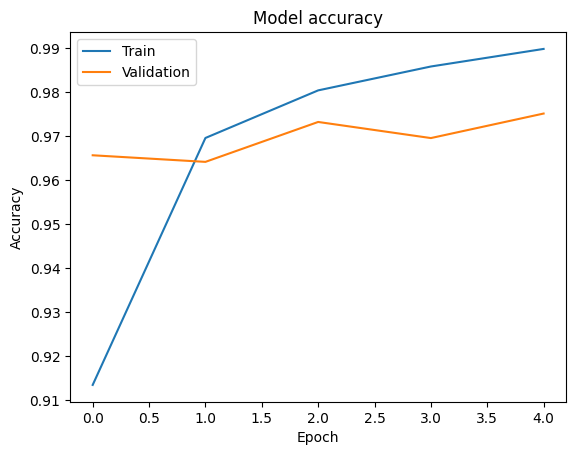

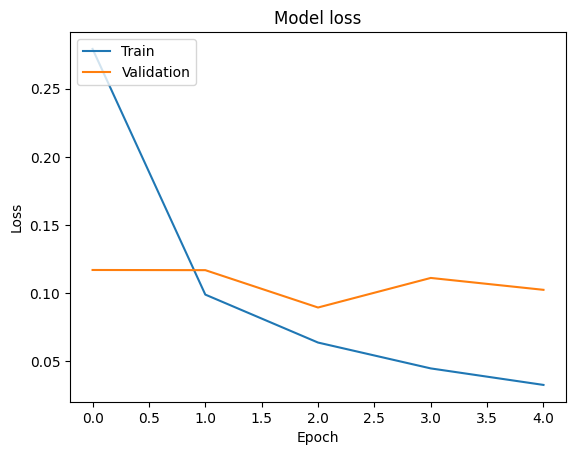

In [42]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

❓❓❓
**EJERCICIO**

Prueba a usar el ejemplo de red neuronal convolucional disponible [aquí](https://keras.io/examples/vision/mnist_convnet/) y a realizar una evaluación similar. Explica qué observas en términos de rendimiento de clasificación y tiempo de entrenamiento.

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 43s 97ms/step - accuracy: 0.7592 - loss: 0.7906 - val_accuracy: 0.9802 - val_loss: 0.0793
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 99ms/step - accuracy: 0.9622 - loss: 0.1241 - val_accuracy: 0.9863 - val_loss: 0.0530
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.9750 - loss: 0.0836 - val_accuracy: 0.9868 - val_loss: 0.0463
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.9776 - loss: 0.0772 - val_accuracy: 0.9897 - val_loss: 0.0405
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.9815 - loss: 0.0614 - val_accuracy: 0.9897 - val_loss: 0.0385
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.9816 - loss: 0.0577 - val_accuracy: 0.9898 - val_loss: 0.0411
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.9836 - loss: 0.0526 - val_accuracy: 0.9892 - val_loss: 0.0395
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - accuracy: 0.9844 - loss: 0.0494 - 

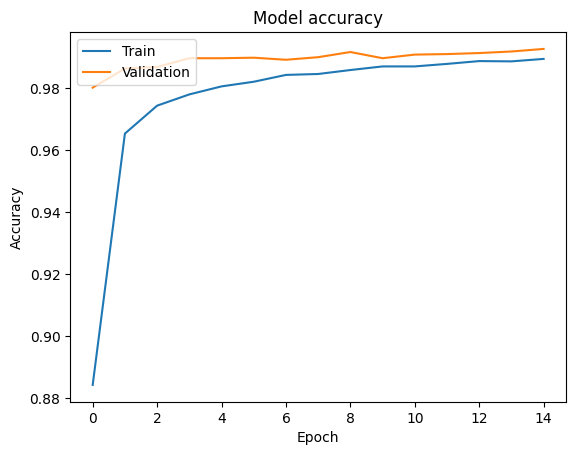

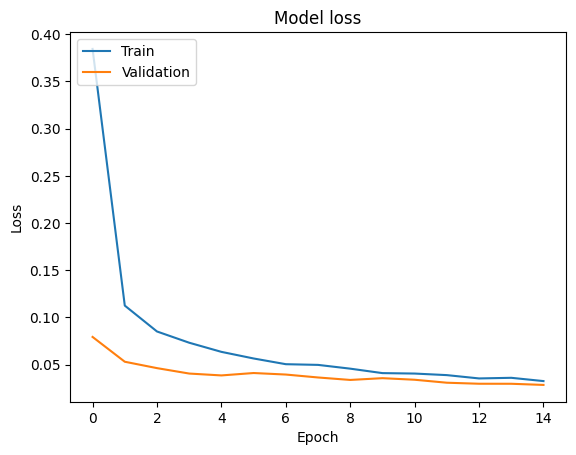

In [49]:
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt

# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Guardar el historial de entrenamiento para graficar después
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# Evaluar el modelo
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)

# Graficar precisión
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Graficar pérdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


En cuanto al accuracy, desde las primeras épocas en validación supera el 98% y se mantiene estable, mientras que en entrenamiento mejora de forma constante hasta aproximarse al mismo valor. Esta cercanía entre ambas curvas indica que el modelo generaliza bien y no parace sobreajustado.

En segundo lugar, para la loss se observa una caída pronunciada en las primeras épocas, especialmente en la pérdida de entrenamiento, lo que refleja un aprendizaje eficiente del modelo. La pérdida de validación también disminuye y se estabiliza en un nivel muy bajo. Esto confirma que el modelo consigue una buena generalización.

## Resumen
* TensorFlow es un *framework* que puede ejecutarse en CPU, GPU y TPU.
* TensorFlow puede calcular el gradiente de cualquier expresión diferenciable.
* Keras es un API para hacer modelos de aprendizaje profundo con TF.
* Objetos claves de TF: tensores, variables, operaciones con tensores y *GradientTape*.
* La clase central de Keras es `Layer`, que encapsula algunos pesos y cálculos. Las capas se unen o ensamblan en **modelos**.
* Antes de entrenar un modelo es necesario elegir un **optimizador**, una **función de pérdida** y una o varias **métricas**: `model.compile()`
* El método `model.fit()` ejecuta el descenso por gradiente por mini-lotes. Permite monitorizar la pérdida y métricas y incluir datos de **validación**.
* Con el modelo entrenado, se pueden hacer predicciones con `model.predict()`.